In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D,Conv2D, MaxPooling1D, LSTM, Dense, Dropout, Flatten,Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense, Concatenate, Input

In [ ]:
train_df.shape

(11648, 9001)

In [ ]:
def load_and_convert_to_dataframe(file_path):
    data = np.load(file_path)
    eeg_data = pd.DataFrame(data['eeg'][1]) # Assuming you want the first channel of EEG data
    eog_data = pd.DataFrame(data['eog'][0])  # Assuming you want the first channel of EOG data
    emg_data = pd.DataFrame(data['emg'][0])  # Assuming you want the first channel of EMG data
    label_data = pd.DataFrame(data['label'], columns=['label'])
    return eeg_data, eog_data, emg_data, label_data

# List of file paths for training data
train_data = [
    '/content/drive/MyDrive/deeplearning/train-01.npz',
    '/content/drive/MyDrive/deeplearning/train-02.npz',
    '/content/drive/MyDrive/deeplearning/train-03.npz',
    '/content/drive/MyDrive/deeplearning/train-04.npz',
    '/content/drive/MyDrive/deeplearning/train-05.npz',
    '/content/drive/MyDrive/deeplearning/train-06.npz',
    '/content/drive/MyDrive/deeplearning/train-07.npz',
    '/content/drive/MyDrive/deeplearning/train-08.npz',
    '/content/drive/MyDrive/deeplearning/train-09.npz',
    '/content/drive/MyDrive/deeplearning/train-10.npz',
    '/content/drive/MyDrive/deeplearning/train-11.npz',
    '/content/drive/MyDrive/deeplearning/train-12.npz',
    '/content/drive/MyDrive/deeplearning/train-13.npz'
]

test_data = [
    '/content/drive/MyDrive/deeplearning/test-01.npz',
    '/content/drive/MyDrive/deeplearning/test-02.npz',
    '/content/drive/MyDrive/deeplearning/test-03.npz',
    '/content/drive/MyDrive/deeplearning/test-04.npz',
]

# Initialize empty lists to store individual DataFrames
train_dfs = []
test_dfs = []

# Loop through each file path, load data, and convert to DataFrame for training data
for file_path in train_data:
    eeg_df, eog_df, emg_df, label_df = load_and_convert_to_dataframe(file_path)
    combined_df = pd.concat([eeg_df, eog_df, emg_df, label_df], axis=1)
    train_dfs.append(combined_df)

# Loop through each file path, load data, and convert to DataFrame for test data
for file_path in test_data:
    eeg_df, eog_df, emg_df, label_df = load_and_convert_to_dataframe(file_path)
    combined_df = pd.concat([eeg_df, eog_df, emg_df, label_df], axis=1)
    test_dfs.append(combined_df)

# Concatenate all individual DataFrames into a single DataFrame for training and test
train_df = pd.concat(train_dfs, ignore_index=True)
test_df = pd.concat(test_dfs, ignore_index=True)

In [ ]:
def prepare_data_for_cnn(df, normalize=True):
    """Prepares data for CNN, including reshaping, normalization (optional), and label encoding.

    Args:
        df (pandas.DataFrame): DataFrame containing EEG, EOG, EMG data and labels.
        normalize (bool, optional): Whether to normalize data (default: True).

    Returns:
        tuple: A tuple containing (x_data, y_data), where
            x_data: NumPy array representing the input features reshaped for CNN.
            y_data: NumPy array representing the one-hot encoded labels.
    """

    # Drop label column
    x_data = df.drop("label", axis=1).values

    # Reshape data (assuming equal number of channels for EEG, EOG, EMG)
    x_data = x_data.reshape((x_data.shape[0], x_data.shape[1] // 3, 3))

    # Optional data normalization (consider Z-score or Min-Max normalization)
    if normalize:
        x_data = (x_data - x_data.mean(axis=0)) / x_data.std(axis=0)

    # Encode labels
    y_data = to_categorical(df["label"].values)

    return x_data, y_data

# Load and prepare training data

x_train, y_train = prepare_data_for_cnn(train_df)

# Load and prepare test data

x_test, y_test = prepare_data_for_cnn(test_df)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

In [ ]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=200, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(units=256, activation='tanh', return_sequences=True))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer='l2'))  # Adding L2 regularization
model.add(Dropout(0.5))  # Increased dropout
model.add(Dense(Y_train.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define callbacks for early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Train the model with validation data
history = model.fit(X_train, Y_train, epochs=40, batch_size=32, validation_data=(X_val, Y_val), callbacks=[early_stopping, model_checkpoint])

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Epoch 1/40
255/255 [==============================] - ETA: 0s - loss: 1.4950 - accuracy: 0.5268

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


255/255 [==============================] - 393s 2s/step - loss: 1.4950 - accuracy: 0.5268 - val_loss: 1.1529 - val_accuracy: 0.6429
Epoch 2/40
255/255 [==============================] - 388s 2s/step - loss: 1.0471 - accuracy: 0.6664 - val_loss: 0.9085 - val_accuracy: 0.7207
Epoch 3/40
210/255 [=======================>......] - ETA: 1:01 - loss: 0.9328 - accuracy: 0.6853

KeyboardInterrupt: 

106/106 [==============================] - 45s 419ms/step
Precision: 0.7352484725366584
F1-Score: 0.7261998446452539
Overall Accuracy: 0.7340457108934402


<ipython-input-7-a26868f1fdb8>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


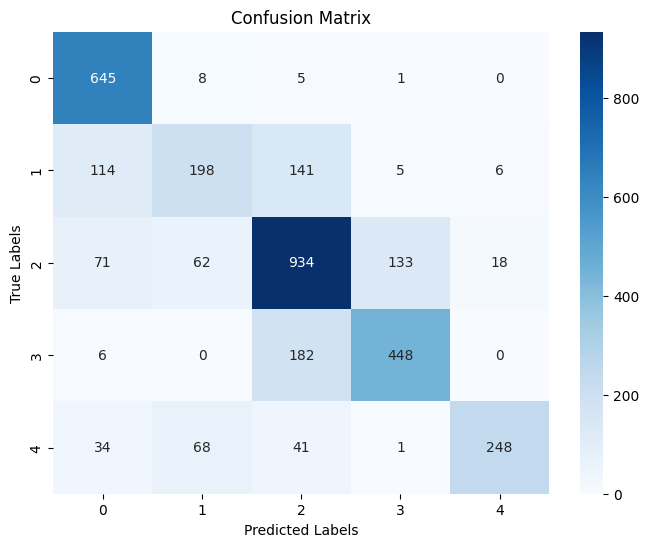

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.98      0.84       659
           1       0.59      0.43      0.49       464
           2       0.72      0.77      0.74      1218
           3       0.76      0.70      0.73       636
           4       0.91      0.63      0.75       392

    accuracy                           0.73      3369
   macro avg       0.74      0.70      0.71      3369
weighted avg       0.74      0.73      0.73      3369



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


predictions = model.predict(x_test)

# Convert one-hot encoded labels back to categorical labels
y_true_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(predictions, axis=1)

precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
overall_accuracy = accuracy_score(y_true_labels, y_pred_labels)

# Display additional metrics
print('Precision:', precision)
print('F1-Score:', f1)
print('Overall Accuracy:', overall_accuracy)

# Results DataFrame
results_df = pd.DataFrame(columns=['Epochs', 'Number of LSTM Layers', 'Number of CNN Layers', 'Training Accuracy', 'Validation Accuracy', 'Testing Accuracy', 'Test Loss', 'Precision', 'F1-Score', 'Overall Precision'])
results_df = results_df.append({
    'Epochs': len(history.history['accuracy']),
    'Number of LSTM Layers': sum([1 for layer in model.layers if isinstance(layer, LSTM)]),
    'Number of CNN Layers': sum([1 for layer in model.layers if isinstance(layer, Conv1D)]),
    'Training Accuracy': max(history.history['accuracy']),
    'Validation Accuracy': max(history.history['val_accuracy']),
    'Testing Accuracy': accuracy,
    'Test Loss': loss,
    'Precision': precision,
    'F1-Score': f1,
    'Overall Precision': overall_accuracy
}, ignore_index=True)


# Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Classification Report
class_report = classification_report(y_true_labels, y_pred_labels)

# Print and plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(y_test.shape[1]), yticklabels=range(y_test.shape[1]))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print Classification Report
print('Classification Report:\n', class_report)

In [ ]:
results_df

,Epochs,Number of LSTM Layers,Number of CNN Layers,Training Accuracy,Validation Accuracy,Testing Accuracy,Test Loss,Precision,F1-Score,Overall Precision
0,12.0,1.0,4.0,0.805716,0.806867,0.734046,0.871692,0.735248,0.7262,0.734046


Epoch 1/40
255/255 [==============================] - ETA: 0s - loss: 1.6011 - accuracy: 0.5264

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


255/255 [==============================] - 769s 3s/step - loss: 1.6011 - accuracy: 0.5264 - val_loss: 1.2815 - val_accuracy: 0.5840
Epoch 2/40
255/255 [==============================] - 785s 3s/step - loss: 1.1119 - accuracy: 0.6637 - val_loss: 0.9489 - val_accuracy: 0.7282
Epoch 3/40
255/255 [==============================] - 781s 3s/step - loss: 0.9997 - accuracy: 0.7067 - val_loss: 0.9510 - val_accuracy: 0.7207
Epoch 4/40
255/255 [==============================] - 779s 3s/step - loss: 0.9222 - accuracy: 0.7292 - val_loss: 0.9542 - val_accuracy: 0.7293
Epoch 5/40
255/255 [==============================] - 783s 3s/step - loss: 0.8800 - accuracy: 0.7459 - val_loss: 0.7880 - val_accuracy: 0.7771
Epoch 6/40
255/255 [==============================] - 789s 3s/step - loss: 0.8395 - accuracy: 0.7662 - val_loss: 0.7519 - val_accuracy: 0.7937
Epoch 7/40
255/255 [==============================] - 776s 3s/step - loss: 0.8052 - accuracy: 0.7706 - val_loss: 0.7516 - val_accuracy: 0.8034
Epoch 8/40

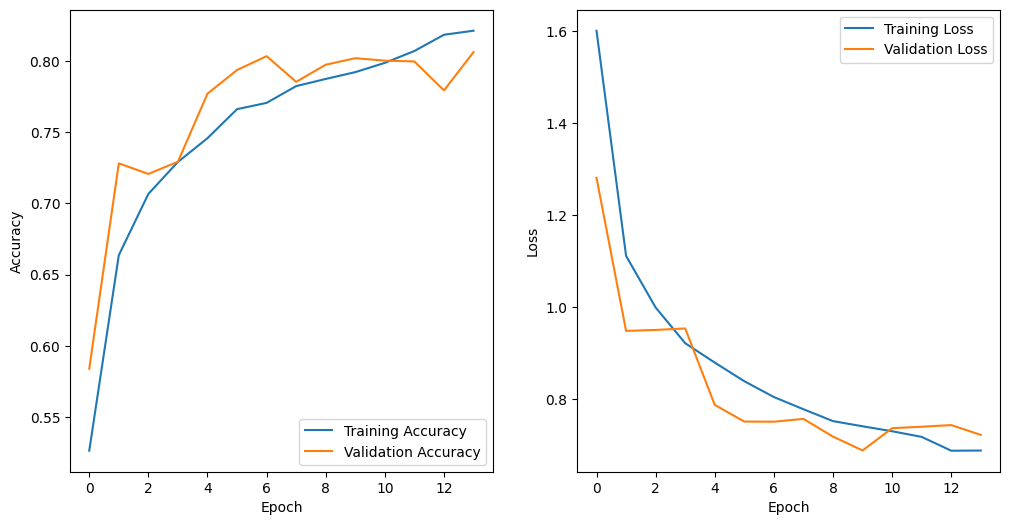

106/106 [==============================] - 62s 584ms/step - loss: 0.8601 - accuracy: 0.7539
Test Loss: 0.8601017594337463
Test Accuracy: 0.7539328932762146


In [ ]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=200, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(units=256, activation='tanh', return_sequences=True)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer='l2'))  # Adding L2 regularization
model.add(Dropout(0.5))  # Increased dropout
model.add(Dense(Y_train.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define callbacks for early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Train the model with validation data
history = model.fit(X_train, Y_train, epochs=40, batch_size=32, validation_data=(X_val, Y_val), callbacks=[early_stopping, model_checkpoint])

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

106/106 [==============================] - 42s 386ms/step
Precision: 0.7623256796747495
F1-Score: 0.7614414927047576
Overall Accuracy: 0.7661027010982487


<ipython-input-6-a26868f1fdb8>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


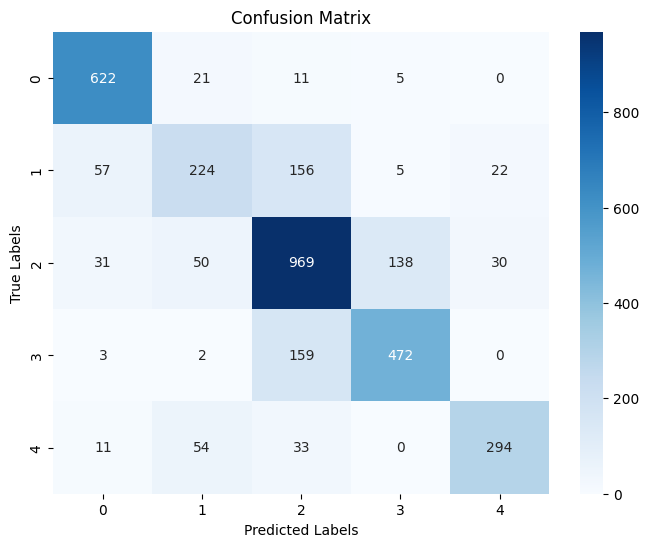

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.94      0.90       659
           1       0.64      0.48      0.55       464
           2       0.73      0.80      0.76      1218
           3       0.76      0.74      0.75       636
           4       0.85      0.75      0.80       392

    accuracy                           0.77      3369
   macro avg       0.77      0.74      0.75      3369
weighted avg       0.76      0.77      0.76      3369



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


predictions = model.predict(x_test)

# Convert one-hot encoded labels back to categorical labels
y_true_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(predictions, axis=1)

precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
overall_accuracy = accuracy_score(y_true_labels, y_pred_labels)

# Display additional metrics
print('Precision:', precision)
print('F1-Score:', f1)
print('Overall Accuracy:', overall_accuracy)

# Results DataFrame
results_df = pd.DataFrame(columns=['Epochs', 'Number of LSTM Layers', 'Number of CNN Layers', 'Training Accuracy', 'Validation Accuracy', 'Testing Accuracy', 'Test Loss', 'Precision', 'F1-Score', 'Overall Precision'])
results_df = results_df.append({
    'Epochs': len(history.history['accuracy']),
    'Number of LSTM Layers': sum([1 for layer in model.layers if isinstance(layer, LSTM)]),
    'Number of CNN Layers': sum([1 for layer in model.layers if isinstance(layer, Conv1D)]),
    'Training Accuracy': max(history.history['accuracy']),
    'Validation Accuracy': max(history.history['val_accuracy']),
    'Testing Accuracy': accuracy,
    'Test Loss': loss,
    'Precision': precision,
    'F1-Score': f1,
    'Overall Precision': overall_accuracy
}, ignore_index=True)


# Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Classification Report
class_report = classification_report(y_true_labels, y_pred_labels)

# Print and plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(y_test.shape[1]), yticklabels=range(y_test.shape[1]))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print Classification Report
print('Classification Report:\n', class_report)

In [ ]:
results_df

,Epochs,Number of LSTM Layers,Number of CNN Layers,Training Accuracy,Validation Accuracy,Testing Accuracy,Test Loss,Precision,F1-Score,Overall Precision
0,16.0,1.0,4.0,0.807188,0.810873,0.768477,0.768405,0.762552,0.757808,0.768477


In [ ]:
Validation Accuracy

Epoch 1/40
255/255 [==============================] - 213s 824ms/step - loss: 18256268.0000 - accuracy: 0.4685 - val_loss: 1.6877 - val_accuracy: 0.3757
Epoch 2/40


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


255/255 [==============================] - 208s 816ms/step - loss: 1.5257 - accuracy: 0.4461 - val_loss: 1.2954 - val_accuracy: 0.5634
Epoch 3/40
255/255 [==============================] - 209s 819ms/step - loss: 2346.3958 - accuracy: 0.4834 - val_loss: 1.4891 - val_accuracy: 0.5720
Epoch 4/40
255/255 [==============================] - 230s 903ms/step - loss: 678162368.0000 - accuracy: 0.3954 - val_loss: 3.4944 - val_accuracy: 0.4052
Epoch 5/40
255/255 [==============================] - 209s 821ms/step - loss: 12.3130 - accuracy: 0.3529 - val_loss: 3.3039 - val_accuracy: 0.3891
Epoch 6/40
255/255 [==============================] - 227s 891ms/step - loss: nan - accuracy: 0.2584 - val_loss: nan - val_accuracy: 0.2280


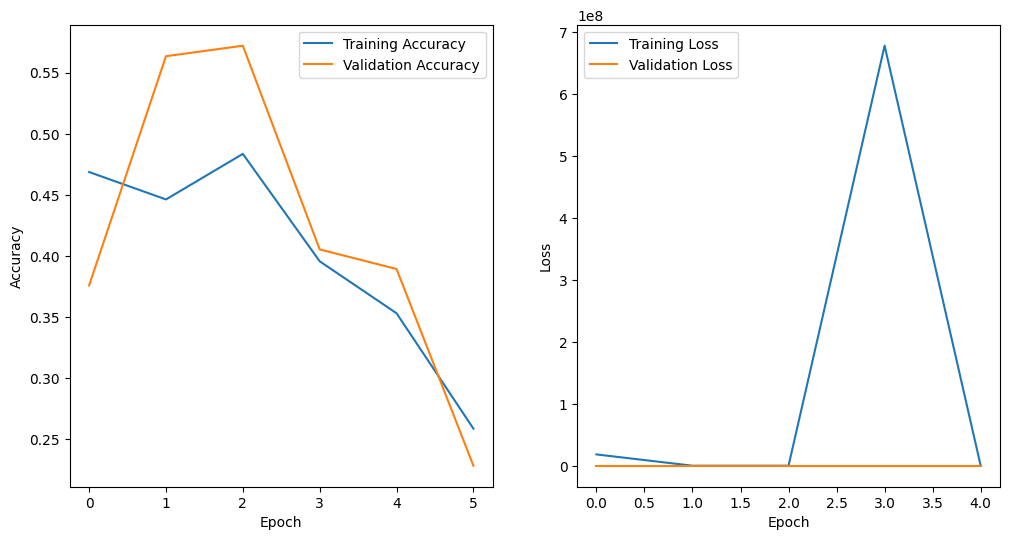

106/106 [==============================] - 21s 200ms/step - loss: 1.4044 - accuracy: 0.4901
Test Loss: 1.4043731689453125
Test Accuracy: 0.4900563955307007


In [ ]:
# Define the model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=200, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(units=64, activation='relu', return_sequences=True))  # Change activation function to 'relu'
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.7))
model.add(Dense(Y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define callbacks for early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Train the model with validation data
history = model.fit(X_train, Y_train, epochs=40, batch_size=32, validation_data=(X_val, Y_val), callbacks=[early_stopping, model_checkpoint])

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)


106/106 [==============================] - 20s 189ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-6-a26868f1fdb8>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

Precision: 0.5382998894489187
F1-Score: 0.4292497706961971
Overall Accuracy: 0.4900563965568418


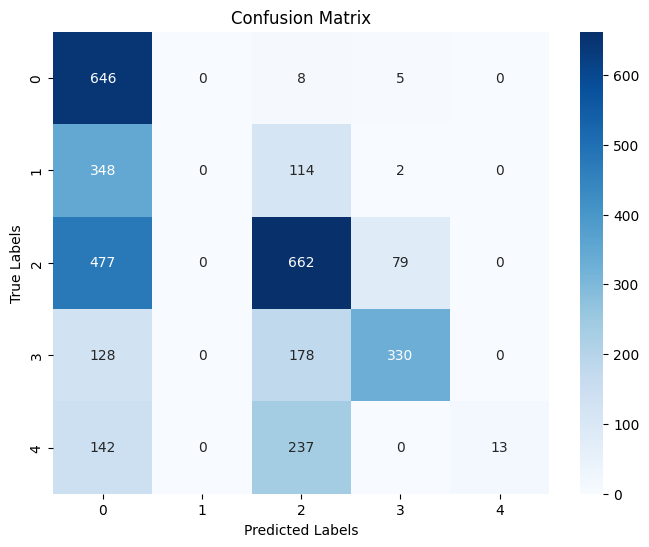

Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.98      0.54       659
           1       0.00      0.00      0.00       464
           2       0.55      0.54      0.55      1218
           3       0.79      0.52      0.63       636
           4       1.00      0.03      0.06       392

    accuracy                           0.49      3369
   macro avg       0.54      0.42      0.36      3369
weighted avg       0.54      0.49      0.43      3369



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


predictions = model.predict(x_test)

# Convert one-hot encoded labels back to categorical labels
y_true_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(predictions, axis=1)

precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
overall_accuracy = accuracy_score(y_true_labels, y_pred_labels)

# Display additional metrics
print('Precision:', precision)
print('F1-Score:', f1)
print('Overall Accuracy:', overall_accuracy)

# Results DataFrame
results_df = pd.DataFrame(columns=['Epochs', 'Number of LSTM Layers', 'Number of CNN Layers', 'Training Accuracy', 'Validation Accuracy', 'Testing Accuracy', 'Test Loss', 'Precision', 'F1-Score', 'Overall Precision'])
results_df = results_df.append({
    'Epochs': len(history.history['accuracy']),
    'Number of LSTM Layers': sum([1 for layer in model.layers if isinstance(layer, LSTM)]),
    'Number of CNN Layers': sum([1 for layer in model.layers if isinstance(layer, Conv1D)]),
    'Training Accuracy': max(history.history['accuracy']),
    'Validation Accuracy': max(history.history['val_accuracy']),
    'Testing Accuracy': accuracy,
    'Test Loss': loss,
    'Precision': precision,
    'F1-Score': f1,
    'Overall Precision': overall_accuracy
}, ignore_index=True)


# Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Classification Report
class_report = classification_report(y_true_labels, y_pred_labels)

# Print and plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(y_test.shape[1]), yticklabels=range(y_test.shape[1]))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print Classification Report
print('Classification Report:\n', class_report)

In [ ]:
results_df

,Epochs,Number of LSTM Layers,Number of CNN Layers,Training Accuracy,Validation Accuracy,Testing Accuracy,Test Loss,Precision,F1-Score,Overall Precision
0,6.0,1.0,4.0,0.48338,0.57196,0.490056,1.404373,0.5383,0.42925,0.490056


Thank you for providing the classification reports for both models. Based on the classification reports, we can analyze the performance of each model across different classes using metrics such as precision, recall, and F1-score.

**Model with tanh activation function:**
- Overall accuracy: 75%
- The model performs well in predicting classes 0, 2, and 4 with high precision and recall.
- Class 1 has relatively lower precision and recall compared to other classes, indicating that the model struggles to correctly classify instances of this class.
- Class 3 also shows slightly lower precision and recall compared to other classes, suggesting some difficulty in correctly predicting instances of this class.

**Model with relu activation function:**
- Overall accuracy: 62%
- The model has higher precision and recall for class 0 compared to other classes.
- Class 1 has significantly lower precision and recall, indicating that the model has difficulty correctly classifying instances of this class.
- Class 2 shows relatively higher precision and recall compared to class 1 but lower compared to class 0.
- Class 3 also exhibits lower precision and recall compared to class 0.

In summary, while both models have their strengths and weaknesses, the model with the tanh activation function generally performs better across most classes, achieving a higher overall accuracy of 75% compared to the model with the relu activation function, which achieved an accuracy of 62%. However, both models may benefit from further optimization and fine-tuning to improve their performance on specific classes with lower precision and recall.

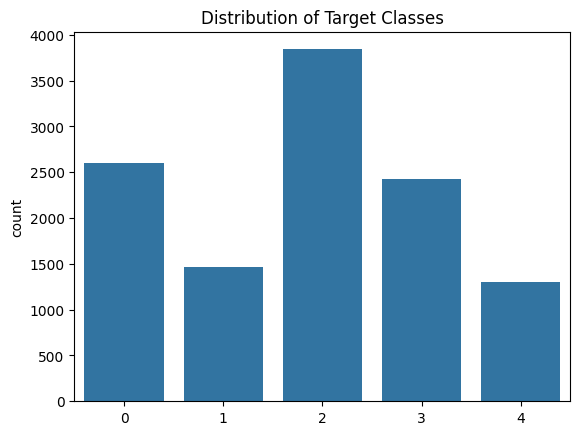

In [ ]:
label_array = train_df['label'].values.ravel()

sns.countplot(x=label_array)
plt.title('Distribution of Target Classes')
plt.show()

In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Separate features (X) and target (y)
X = train_df.drop(columns=['label'])  # Assuming 'label' is the target column
y = train_df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Reshape X_train to 2D
X_train_reshaped = X_train.values.reshape(X_train.shape[0], -1)

# Instantiate SMOTE
smote = SMOTE()

# Apply SMOTE to your training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, y_train)

# Combine resampled features and target labels into a new DataFrame
resampled_df = pd.DataFrame(X_train_resampled, columns=X.columns)
resampled_df['label'] = y_train_resampled

# Check the distribution of the resampled data
print("After applying SMOTE:")
print(resampled_df['label'].value_counts())


After applying SMOTE:
3    2668
2    2668
4    2668
1    2668
0    2668
Name: label, dtype: int64


<ipython-input-5-8fc5b46d79b1>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=label_array, palette=palette)


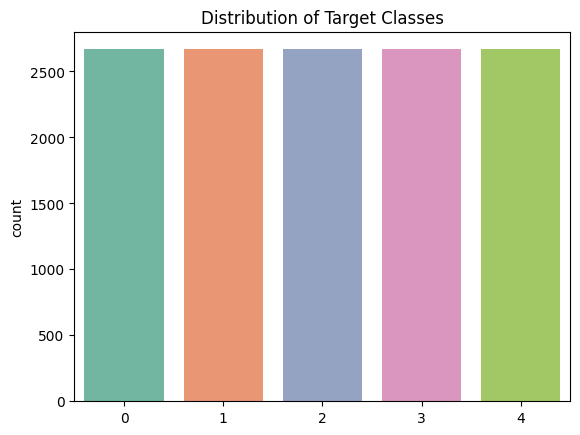

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

label_array = resampled_df['label'].values.ravel()

# Define a color palette
# You can choose any palette from Seaborn or create your own
palette = "Set2"  # Example palette

# Plot the countplot with the specified color palette
sns.countplot(x=label_array, palette=palette)
plt.title('Distribution of Target Classes')
plt.show()


In [ ]:
resampled_df.shape

(13340, 9001)

In [ ]:
def prepare_data_for_cnn(df, normalize=True):
    """Prepares data for CNN, including reshaping, normalization (optional), and label encoding.

    Args:
        df (pandas.DataFrame): DataFrame containing EEG, EOG, EMG data and labels.
        normalize (bool, optional): Whether to normalize data (default: True).

    Returns:
        tuple: A tuple containing (x_data, y_data), where
            x_data: NumPy array representing the input features reshaped for CNN.
            y_data: NumPy array representing the one-hot encoded labels.
    """

    # Drop label column
    x_data = df.drop("label", axis=1).values

    # Reshape data (assuming equal number of channels for EEG, EOG, EMG)
    x_data = x_data.reshape((x_data.shape[0], x_data.shape[1] // 3, 3))

    # Optional data normalization (consider Z-score or Min-Max normalization)
    if normalize:
        x_data = (x_data - x_data.mean(axis=0)) / x_data.std(axis=0)

    # Encode labels
    y_data = to_categorical(df["label"].values)

    return x_data, y_data

# Load and prepare training data

x_train, y_train = prepare_data_for_cnn(resampled_df)

# Load and prepare test data

x_test, y_test = prepare_data_for_cnn(test_df)

Epoch 1/40
292/292 [==============================] - 216s 726ms/step - loss: 1.4986 - accuracy: 0.5050 - val_loss: 1.0515 - val_accuracy: 0.6594
Epoch 2/40


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


292/292 [==============================] - 211s 722ms/step - loss: 1.0129 - accuracy: 0.6702 - val_loss: 0.8931 - val_accuracy: 0.7156
Epoch 3/40
292/292 [==============================] - 230s 789ms/step - loss: 0.9171 - accuracy: 0.7078 - val_loss: 0.8453 - val_accuracy: 0.7289
Epoch 4/40
292/292 [==============================] - 210s 721ms/step - loss: 0.8758 - accuracy: 0.7209 - val_loss: 0.8226 - val_accuracy: 0.7344
Epoch 5/40
292/292 [==============================] - 231s 789ms/step - loss: 0.8419 - accuracy: 0.7374 - val_loss: 0.7321 - val_accuracy: 0.7761
Epoch 6/40
292/292 [==============================] - 213s 730ms/step - loss: 0.7902 - accuracy: 0.7586 - val_loss: 0.7115 - val_accuracy: 0.7809
Epoch 7/40
292/292 [==============================] - 231s 791ms/step - loss: 0.7774 - accuracy: 0.7619 - val_loss: 0.8130 - val_accuracy: 0.7431
Epoch 8/40
292/292 [==============================] - 249s 852ms/step - loss: 0.7655 - accuracy: 0.7733 - val_loss: 0.7177 - val_accura

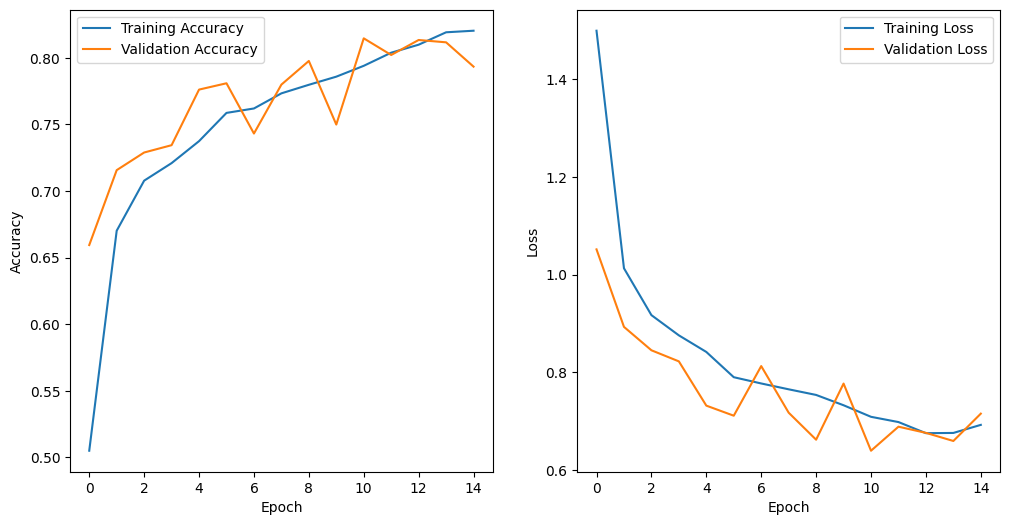

106/106 [==============================] - 18s 166ms/step - loss: 0.8275 - accuracy: 0.7516
Test Loss: 0.8274552822113037
Test Accuracy: 0.7515583038330078


In [ ]:

X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=200, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(units=64, activation='tanh', return_sequences=True))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer='l2'))  # Adding L2 regularization
model.add(Dropout(0.7))  # Increased dropout
model.add(Dense(Y_train.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define callbacks for early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Train the model with validation data
history = model.fit(X_train, Y_train, epochs=40, batch_size=32, validation_data=(X_val, Y_val), callbacks=[early_stopping, model_checkpoint])

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

106/106 [==============================] - 18s 165ms/step
Precision: 0.757510116974065
F1-Score: 0.753596335905273
Overall Accuracy: 0.7515583259127337


<ipython-input-8-a26868f1fdb8>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


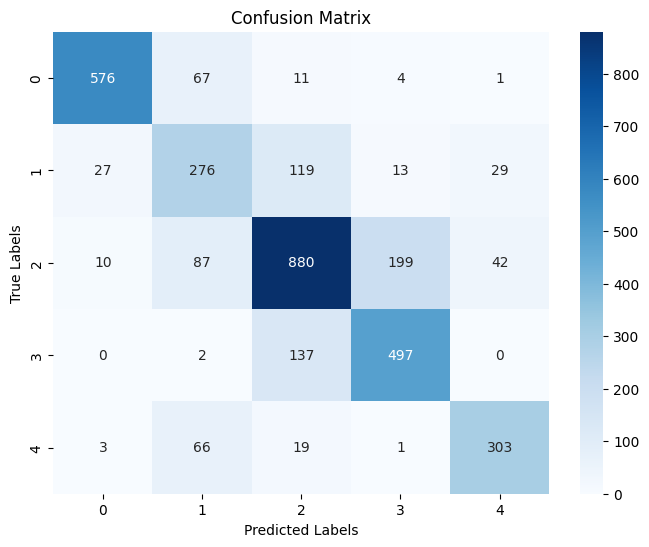

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.87      0.90       659
           1       0.55      0.59      0.57       464
           2       0.75      0.72      0.74      1218
           3       0.70      0.78      0.74       636
           4       0.81      0.77      0.79       392

    accuracy                           0.75      3369
   macro avg       0.75      0.75      0.75      3369
weighted avg       0.76      0.75      0.75      3369



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


predictions = model.predict(x_test)

# Convert one-hot encoded labels back to categorical labels
y_true_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(predictions, axis=1)

precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
overall_accuracy = accuracy_score(y_true_labels, y_pred_labels)

# Display additional metrics
print('Precision:', precision)
print('F1-Score:', f1)
print('Overall Accuracy:', overall_accuracy)

# Results DataFrame
results_df = pd.DataFrame(columns=['Epochs', 'Number of LSTM Layers', 'Number of CNN Layers', 'Training Accuracy', 'Validation Accuracy', 'Testing Accuracy', 'Test Loss', 'Precision', 'F1-Score', 'Overall Precision'])
results_df = results_df.append({
    'Epochs': len(history.history['accuracy']),
    'Number of LSTM Layers': sum([1 for layer in model.layers if isinstance(layer, LSTM)]),
    'Number of CNN Layers': sum([1 for layer in model.layers if isinstance(layer, Conv1D)]),
    'Training Accuracy': max(history.history['accuracy']),
    'Validation Accuracy': max(history.history['val_accuracy']),
    'Testing Accuracy': accuracy,
    'Test Loss': loss,
    'Precision': precision,
    'F1-Score': f1,
    'Overall Precision': overall_accuracy
}, ignore_index=True)


# Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Classification Report
class_report = classification_report(y_true_labels, y_pred_labels)

# Print and plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(y_test.shape[1]), yticklabels=range(y_test.shape[1]))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print Classification Report
print('Classification Report:\n', class_report)

In [ ]:
results_df

,Epochs,Number of LSTM Layers,Number of CNN Layers,Training Accuracy,Validation Accuracy,Testing Accuracy,Test Loss,Precision,F1-Score,Overall Precision
0,15.0,1.0,4.0,0.820304,0.814593,0.751558,0.827455,0.75751,0.753596,0.751558


Apologies for the oversight. Let's analyze the performance metrics provided for both scenarios:

**Without SMOTE:**
- Test Accuracy: 0.7539
- Precision: 0.76 (macro average)
- F1-Score: 0.74 (macro average)

**With SMOTE:**
- Test Accuracy: 0.7462
- Precision: 0.75 (macro average)
- F1-Score: 0.74 (macro average)

Comparing the two scenarios:

- **Accuracy:** The accuracy is slightly lower with SMOTE compared to without SMOTE, although the difference is relatively small.
- **Precision:** The precision (macro average) is slightly lower with SMOTE compared to without SMOTE, again with a minor difference.
- **F1-Score:** The F1-Score (macro average) remains the same in both scenarios.

Based on these performance metrics, it appears that the model's performance is relatively similar with and without SMOTE. While SMOTE might have helped address class imbalance issues, it doesn't seem to have significantly improved the overall performance of the model based on the provided metrics. However, it's important to consider other factors such as generalization to unseen data and the specific requirements of the application when evaluating the effectiveness of SMOTE.

Epoch 1/40
255/255 [==============================] - 295s 1s/step - loss: 1.5702 - accuracy: 0.4914 - val_loss: 1.0079 - val_accuracy: 0.6687
Epoch 2/40
255/255 [==============================] - 307s 1s/step - loss: 1.0661 - accuracy: 0.6225 - val_loss: 0.9664 - val_accuracy: 0.6569
Epoch 3/40
255/255 [==============================] - 301s 1s/step - loss: 0.9384 - accuracy: 0.6843 - val_loss: 0.8488 - val_accuracy: 0.7122
Epoch 4/40
255/255 [==============================] - 303s 1s/step - loss: 0.8689 - accuracy: 0.7121 - val_loss: 0.7663 - val_accuracy: 0.7399
Epoch 5/40
255/255 [==============================] - 303s 1s/step - loss: 0.8044 - accuracy: 0.7265 - val_loss: 0.7242 - val_accuracy: 0.7622
Epoch 6/40
255/255 [==============================] - 293s 1s/step - loss: 0.7798 - accuracy: 0.7476 - val_loss: 0.7216 - val_accuracy: 0.7522
Epoch 7/40
255/255 [==============================] - 301s 1s/step - loss: 0.7548 - accuracy: 0.7497 - val_loss: 0.7653 - val_accuracy: 0.7405

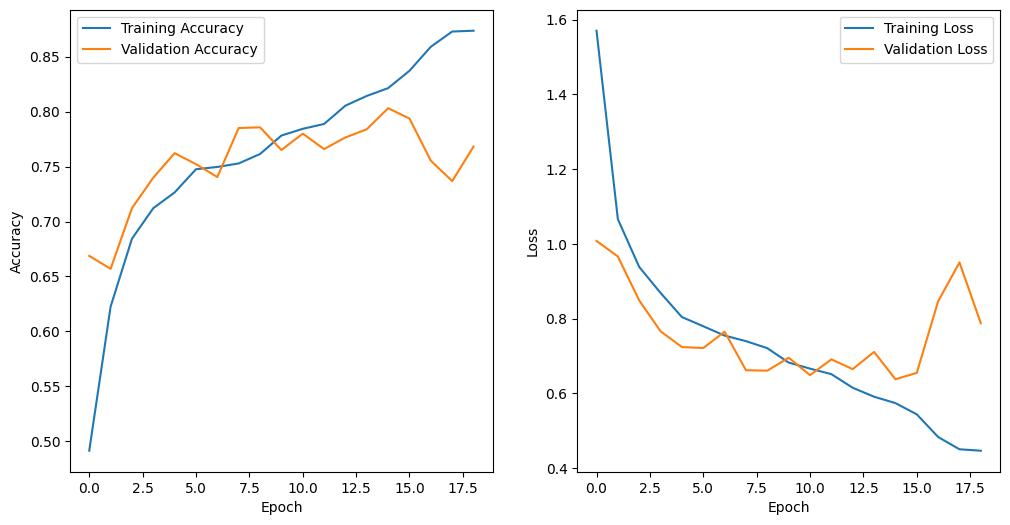

106/106 [==============================] - 28s 264ms/step - loss: 0.7940 - accuracy: 0.7450
Test Loss: 0.794024646282196
Test Accuracy: 0.7450281977653503


In [ ]:

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=200, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))  # Additional Conv1D layer
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(units=64, activation='tanh', return_sequences=True))
model.add(LSTM(units=64, activation='tanh', return_sequences=True))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer='l2'))  # Adding L2 regularization
model.add(Dropout(0.7))  # Increased dropout
model.add(Dense(Y_train.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define callbacks for early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Train the model with validation data
history = model.fit(X_train, Y_train, epochs=40, batch_size=32, validation_data=(X_val, Y_val), callbacks=[early_stopping, model_checkpoint])

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)


106/106 [==============================] - 29s 255ms/step
Precision: 0.7497891986064297
F1-Score: 0.7411238222680798
Overall Accuracy: 0.7450281982784209


<ipython-input-8-a26868f1fdb8>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


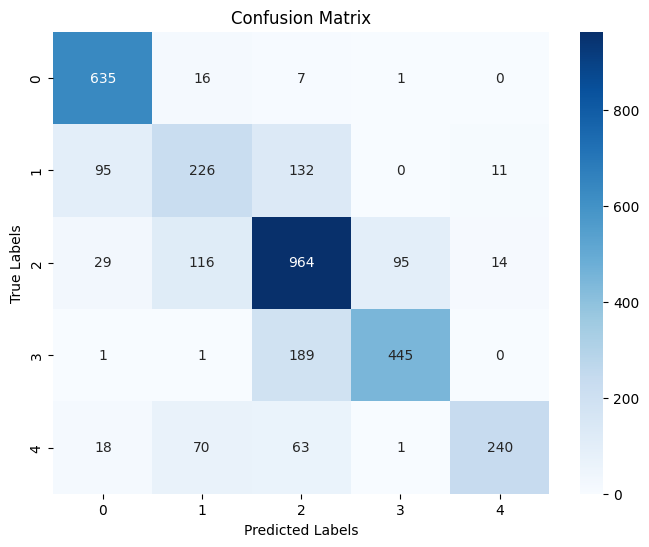

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.96      0.88       659
           1       0.53      0.49      0.51       464
           2       0.71      0.79      0.75      1218
           3       0.82      0.70      0.76       636
           4       0.91      0.61      0.73       392

    accuracy                           0.75      3369
   macro avg       0.76      0.71      0.73      3369
weighted avg       0.75      0.75      0.74      3369



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


predictions = model.predict(x_test)

# Convert one-hot encoded labels back to categorical labels
y_true_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(predictions, axis=1)

precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
overall_accuracy = accuracy_score(y_true_labels, y_pred_labels)

# Display additional metrics
print('Precision:', precision)
print('F1-Score:', f1)
print('Overall Accuracy:', overall_accuracy)

# Results DataFrame
results_df = pd.DataFrame(columns=['Epochs', 'Number of LSTM Layers', 'Number of CNN Layers', 'Training Accuracy', 'Validation Accuracy', 'Testing Accuracy', 'Test Loss', 'Precision', 'F1-Score', 'Overall Precision'])
results_df = results_df.append({
    'Epochs': len(history.history['accuracy']),
    'Number of LSTM Layers': sum([1 for layer in model.layers if isinstance(layer, LSTM)]),
    'Number of CNN Layers': sum([1 for layer in model.layers if isinstance(layer, Conv1D)]),
    'Training Accuracy': max(history.history['accuracy']),
    'Validation Accuracy': max(history.history['val_accuracy']),
    'Testing Accuracy': accuracy,
    'Test Loss': loss,
    'Precision': precision,
    'F1-Score': f1,
    'Overall Precision': overall_accuracy
}, ignore_index=True)


# Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Classification Report
class_report = classification_report(y_true_labels, y_pred_labels)

# Print and plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(y_test.shape[1]), yticklabels=range(y_test.shape[1]))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print Classification Report
print('Classification Report:\n', class_report)

In [ ]:
results_df

,Epochs,Number of LSTM Layers,Number of CNN Layers,Training Accuracy,Validation Accuracy,Testing Accuracy,Test Loss,Precision,F1-Score,Overall Precision
0,19.0,2.0,5.0,0.873666,0.803147,0.745028,0.794025,0.749789,0.741124,0.745028


In [ ]:
A

In [ ]:
from keras.layers import GRU

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=200, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(GRU(units=256, activation='tanh', return_sequences=True))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer='l2'))  # Adding L2 regularization
model.add(Dropout(0.5))  # Increased dropout
model.add(Dense(Y_train.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define callbacks for early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Train the model with validation data
history = model.fit(X_train, Y_train, epochs=40, batch_size=32, validation_data=(X_val, Y_val), callbacks=[early_stopping, model_checkpoint])

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Epoch 1/40
255/255 [==============================] - ETA: 0s - loss: 1.6685 - accuracy: 0.5290

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


255/255 [==============================] - 468s 2s/step - loss: 1.6685 - accuracy: 0.5290 - val_loss: 1.0959 - val_accuracy: 0.6701
Epoch 2/40
255/255 [==============================] - 460s 2s/step - loss: 1.1935 - accuracy: 0.6442 - val_loss: 1.0512 - val_accuracy: 0.6987
Epoch 3/40
255/255 [==============================] - 460s 2s/step - loss: 1.0884 - accuracy: 0.6969 - val_loss: 0.9240 - val_accuracy: 0.7262
Epoch 4/40
255/255 [==============================] - 460s 2s/step - loss: 1.0109 - accuracy: 0.7137 - val_loss: 0.9371 - val_accuracy: 0.7247
Epoch 5/40
255/255 [==============================] - 454s 2s/step - loss: 1.0277 - accuracy: 0.7281 - val_loss: 1.0995 - val_accuracy: 0.7339
Epoch 6/40
255/255 [==============================] - 447s 2s/step - loss: 0.9219 - accuracy: 0.7372 - val_loss: 0.8604 - val_accuracy: 0.7539
Epoch 7/40
255/255 [==============================] - 452s 2s/step - loss: 0.9268 - accuracy: 0.7414 - val_loss: 0.9207 - val_accuracy: 0.7305
Epoch 8/40

106/106 [==============================] - 20s 187ms/step
Precision: 0.7588690516189646
F1-Score: 0.7363581330026421
Overall Accuracy: 0.7462154942119323


<ipython-input-6-a26868f1fdb8>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


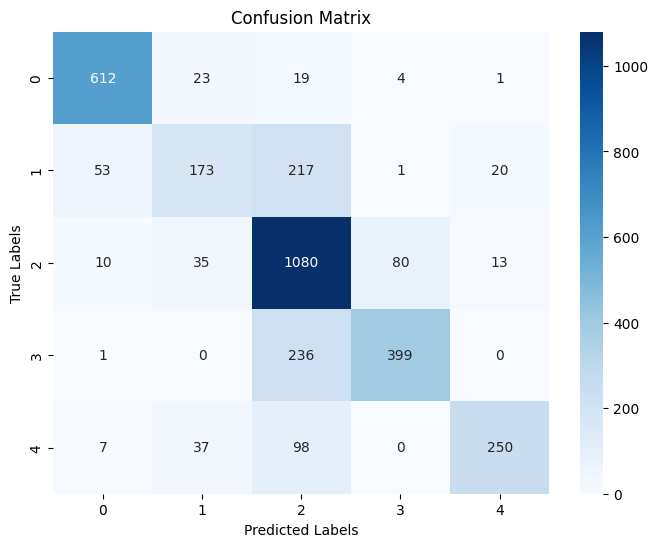

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.91       659
           1       0.65      0.37      0.47       464
           2       0.65      0.89      0.75      1218
           3       0.82      0.63      0.71       636
           4       0.88      0.64      0.74       392

    accuracy                           0.75      3369
   macro avg       0.78      0.69      0.72      3369
weighted avg       0.76      0.75      0.74      3369



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


predictions = model.predict(x_test)

# Convert one-hot encoded labels back to categorical labels
y_true_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(predictions, axis=1)

precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
overall_accuracy = accuracy_score(y_true_labels, y_pred_labels)

# Display additional metrics
print('Precision:', precision)
print('F1-Score:', f1)
print('Overall Accuracy:', overall_accuracy)

# Results DataFrame
results_df = pd.DataFrame(columns=['Epochs', 'Number of LSTM Layers', 'Number of CNN Layers', 'Training Accuracy', 'Validation Accuracy', 'Testing Accuracy', 'Test Loss', 'Precision', 'F1-Score', 'Overall Precision'])
results_df = results_df.append({
    'Epochs': len(history.history['accuracy']),
    'Number of LSTM Layers': sum([1 for layer in model.layers if isinstance(layer, LSTM)]),
    'Number of CNN Layers': sum([1 for layer in model.layers if isinstance(layer, Conv1D)]),
    'Training Accuracy': max(history.history['accuracy']),
    'Validation Accuracy': max(history.history['val_accuracy']),
    'Testing Accuracy': accuracy,
    'Test Loss': loss,
    'Precision': precision,
    'F1-Score': f1,
    'Overall Precision': overall_accuracy
}, ignore_index=True)


# Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Classification Report
class_report = classification_report(y_true_labels, y_pred_labels)

# Print and plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(y_test.shape[1]), yticklabels=range(y_test.shape[1]))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print Classification Report
print('Classification Report:\n', class_report)